In [9]:
!pip install datasets
!pip install pandas
!pip install pandas
!pip install scikit-learn 
!pip install matplotlib
!pip install seaborn
!pip install sentence_transformers

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.6/766.6 MB 53.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 94.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [2]:
from datasets import Dataset

import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# The unlabeled data (-1) will remain unchanged.
mapping = {
    "Jndenlandsk": 1,
    "Udenlandsk": 2,
    "Bekjendtgjørelser": 3,
    "-1": -1
}

In [3]:
embedding_list = ['MeMo-BERT-03', 'DFM', 'e5-large', 'e5-large-instruct']

### Check chunk length

In [ ]:
ds = Dataset.load_from_disk(f'../../DATA/NEWSPAPERS/embeddings_sample_classifier/{embedding_list[0]}/mean_output')
df = ds.to_pandas()

df.columns

Index(['article_id', 'embedding', 'n_chunks_orig', 'clean_category'], dtype='object')

In [13]:
df.head()

,article_id,embedding,n_chunks_orig,clean_category
0,lol_60633,"[-0.19128695130348206, 0.24198412895202637, -0...",1,Bekjendtgjørelser
1,lol_12841,"[-0.06094222143292427, -0.04036889225244522, -...",1,Bekjendtgjørelser
2,lol_08919,"[-0.14956089854240417, -0.04609327460639179, -...",2,Bekjendtgjørelser
3,lol_52440,"[-0.0787305235862732, -0.0256968904286623, -0....",1,Bekjendtgjørelser
4,lol_06887,"[-0.10685992985963821, -0.17940831184387207, -...",1,Bekjendtgjørelser


<Axes: ylabel='Frequency'>

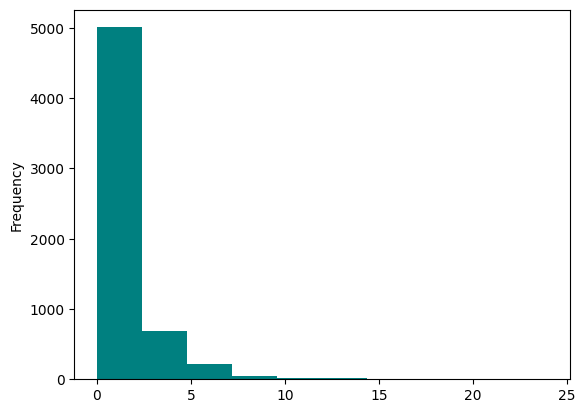

In [7]:
df['n_chunks_orig'].plot(kind='hist', bins=10, color='teal')

In [12]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('MiMe-MeMo/MeMo-BERT-03')
print(model.max_seq_length)

No sentence-transformers model found with name MiMe-MeMo/MeMo-BERT-03. Creating a new one with mean pooling.


config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of XLMRobertaModel were not initialized from the model checkpoint at MiMe-MeMo/MeMo-BERT-03 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/423 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.80M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

512


### Train classification model with different embeddings, using SelfTrainClassifier

In [ ]:
report_filepath = '../results/classification_reports_semi_supervised.txt'
with open(report_filepath, 'w') as report_file:
    for item in embedding_list:

        ds = Dataset.load_from_disk(f'../../DATA/NEWSPAPERS/embeddings_sample_classifier/{item}/mean_output')
        df = ds.to_pandas()

        # Check the shape of each embedding
        df['embedding_shape'] = df['embedding'].apply(lambda x: np.array(x).shape)
        expected_dim = df['embedding_shape'].max()[0]
        df = df[df['embedding'].apply(lambda x: np.array(x).shape == (expected_dim,))].copy()

        # Apply the mapping: if the value is -1, keep it; otherwise, map the string.
        df['clean_category'] = df['clean_category'].apply(lambda x: mapping[x] if x != -1 else -1)

        # Assume df is your DataFrame with columns 'embedding' and 'label'
        # Separate labeled and unlabeled data
        labeled_df = df[df['clean_category'] != -1].copy()
        unlabeled_df = df[df['clean_category'] == -1].copy()

        # Split the labeled data into training and test sets.
        # Stratify to maintain class balance in the test set.
        train_labeled_df, test_df = train_test_split(
            labeled_df, 
            test_size=0.2, 
            random_state=42, 
            stratify=labeled_df['clean_category']
        )

        # Combine the training labeled data with all unlabeled data
        train_df = pd.concat([train_labeled_df, unlabeled_df]).sample(frac=1, random_state=42).reset_index(drop=True)

        # Prepare training data
        X_train = np.vstack(train_df['embedding'].values)
        y_train = train_df['clean_category'].values

        # Prepare test data
        X_test = np.vstack(test_df['embedding'].values)
        y_test = test_df['clean_category'].values

        # Define the base classifier
        base_clf = LogisticRegression(max_iter=1000)

        # Create the self-training classifier with a confidence threshold
        self_training_clf = SelfTrainingClassifier(base_clf, threshold=0.8, verbose=True)

        # Train on the training set (labeled + unlabeled)
        print(f'Train classifier on {item} embeddings')
        self_training_clf.fit(X_train, y_train)

        # Evaluate on the separate test set
        predictions = self_training_clf.predict(X_test)
        report = classification_report(y_test, predictions)
        
        # Write the classification report to the text file
        report_file.write(f"Classification Report for {item}:\n")
        report_file.write(report)
        report_file.write("\n" + "="*80 + "\n\n")

        # Compute the confusion matrix
        cm = confusion_matrix(y_test, predictions)

        # Plotting the confusion matrix as a heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=list(mapping.keys())[:3], yticklabels=list(mapping.keys())[:3])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.savefig(f'../figures/cm_{item}_semi_supervised.pdf', bbox_inches='tight')
        plt.close()  # close the figure to free up memory


Train classifier on MeMo-BERT-03 embeddings
End of iteration 1, added 2044 new labels.
End of iteration 2, added 253 new labels.
End of iteration 3, added 62 new labels.
End of iteration 4, added 19 new labels.
End of iteration 5, added 6 new labels.
End of iteration 6, added 4 new labels.
End of iteration 7, added 8 new labels.
End of iteration 8, added 6 new labels.
End of iteration 9, added 1 new labels.
Train classifier on DFM embeddings
End of iteration 1, added 2646 new labels.
End of iteration 2, added 131 new labels.
End of iteration 3, added 39 new labels.
End of iteration 4, added 20 new labels.
End of iteration 5, added 11 new labels.
End of iteration 6, added 5 new labels.
End of iteration 7, added 3 new labels.
End of iteration 8, added 2 new labels.
End of iteration 9, added 1 new labels.
End of iteration 10, added 1 new labels.
Train classifier on e5-large embeddings
End of iteration 1, added 708 new labels.
End of iteration 2, added 301 new labels.
End of iteration 3, a

In [5]:
# Filepath to save the classification reports
report_filepath = '../results/classification_reports_supervised.txt'
with open(report_filepath, 'w') as report_file:
    for item in embedding_list:

        # Load the dataset for the current embedding
        ds = Dataset.load_from_disk(f'../embeddings_sample_classifier/{item}/mean_output')
        df = ds.to_pandas()

        # Check the shape of each embedding and filter only those with the expected dimension
        df['embedding_shape'] = df['embedding'].apply(lambda x: np.array(x).shape)
        expected_dim = df['embedding_shape'].max()[0]
        df = df[df['embedding'].apply(lambda x: np.array(x).shape == (expected_dim,))].copy()

        # Map the category labels; keep -1 for unlabeled data
        df['clean_category'] = df['clean_category'].apply(lambda x: mapping[x] if x != -1 else -1)

        # Use only the labeled data (i.e., drop the unlabeled samples)
        labeled_df = df[df['clean_category'] != -1].copy()

        # Split the labeled data into training and test sets (with stratification)
        train_df, test_df = train_test_split(
            labeled_df, 
            test_size=0.2, 
            random_state=42, 
            stratify=labeled_df['clean_category']
        )

        # Prepare training and test features/labels
        X_train = np.vstack(train_df['embedding'].values)
        y_train = train_df['clean_category'].values

        X_test = np.vstack(test_df['embedding'].values)
        y_test = test_df['clean_category'].values

        # Instantiate the Logistic Regression classifier
        clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

        # Train the classifier on the labeled training data
        print(f'Train classifier on {item} embeddings')
        clf.fit(X_train, y_train)

        # Evaluate on the test set
        predictions = clf.predict(X_test)
        report = classification_report(y_test, predictions)
        
        # Write the classification report to the text file
        report_file.write(f"Classification Report for {item}:\n")
        report_file.write(report)
        report_file.write("\n" + "="*80 + "\n\n")

        # Compute and plot the confusion matrix
        cm = confusion_matrix(y_test, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=list(mapping.keys())[:3], 
                    yticklabels=list(mapping.keys())[:3])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.savefig(f'../figures/cm_{item}_supervised.pdf', bbox_inches='tight')
        plt.close()

Train classifier on MeMo-BERT-03 embeddings
Train classifier on DFM embeddings
Train classifier on e5-large embeddings
Train classifier on e5-large-instruct embeddings
